# Dynamics

Having found a way to calculate the period of a pendulum, we can now see if we can model its dynamics -- for example, finding the angle $\theta$ as a function of time.

Recall, the equations of motion for the pendulum are:
\begin{align}
\frac{d \theta}{dt}&= \frac{v}{L} \\
m \frac{d v}{dt}&=-m g \sin(\theta)
\end{align}

As before, our first step will be to *adimensionalize* these equations.  The angle $\theta$ is already dimensionless.  The characteristic time in the problem is $T_0=\sqrt{L/g}$ and the characteristic velocity is $v_0=L/T_0=\sqrt{g L}$.

If we are a little sloppy -- and use the same symbols for the dimensional and dimensionless quantities -- we get
\begin{align}
\frac{d \theta}{dt}&= v \\
\frac{d v}{dt}&=- \sin(\theta)
\end{align}

## Phase Plane Portrait

Before doing anything quantitative, we want to get a qualitative understanding of the dynamics.  Since we are only dealing with a 2-dimensional phase space, we can come to that understanding by using a *phase plane portrait*.  That means at every $\theta,v$ we draw a vector which represents the rate of change of that quantity.

In [1]:
using Plots

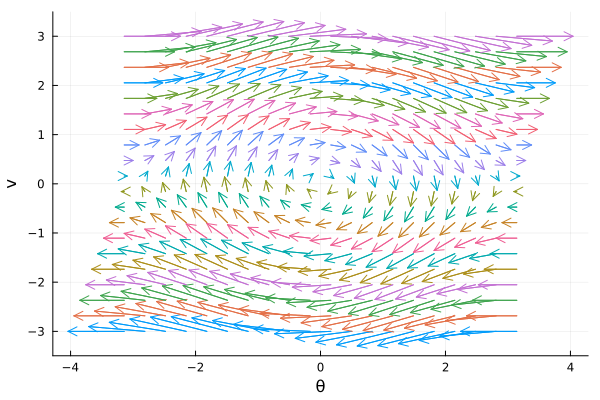

In [2]:
θ_list=range(-pi,pi,20)
v_list=range(-3,3,20)
θ_grid=[θ for θ in θ_list,v in v_list]
v_grid=[v for θ in θ_list,v in v_list]
dθdt_grid=v_grid
dvdt_grid=-sin.(θ_grid)
Plots.quiver(θ_grid,v_grid,quiver=(dθdt_grid,dvdt_grid).*0.3,xlabel="θ",ylabel="v")

To make this clearer, we can use that energy is conserved in this system.  In these units the energy is
$$
E=\frac{1}{2} v^2 - \cos(\theta)
$$

Thus we can plot the energy contours on the phase plane portrait, and the dynamics must follow them

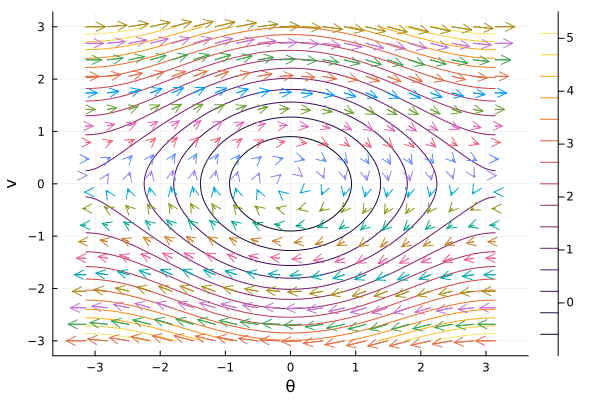

In [3]:
θ_finelist=range(-pi,pi,120)
v_finelist=range(-3,3,100)
E_function(θ,v)=(1/2)*v^2-cos(θ)
E_finegrid= [E_function(θ,v) for θ in θ_finelist ,  v in v_finelist]
Plots.contour(θ_finelist,v_finelist,E_finegrid')
Plots.quiver!(θ_grid,v_grid,quiver=(dθdt_grid,dvdt_grid).*0.1,xlabel="θ",ylabel="v")

We see that there are two qualitatively different types of orbits:

At small energies we have closed orbits, where the pendulum is oscillating back and forth.

At large energies we have open orbits, where the pendulum spins round and round, like a propeller.  In the phase plane portrait, the boundary between those is the **separatrix**.

We also see two special points: (θ,v)=(0,0) is a point of *stable equilibrium*, while (θ,v)=(π,0) is an unstable equilibrium.

## Prettier Phase Plane Portraits

That phase plane portrait works, but was kind of ugly.  Lets try a different plotting package.

In [4]:
using CairoMakie

In [5]:
norms= @. 4*sqrt(dθdt_grid^2+dvdt_grid^2);

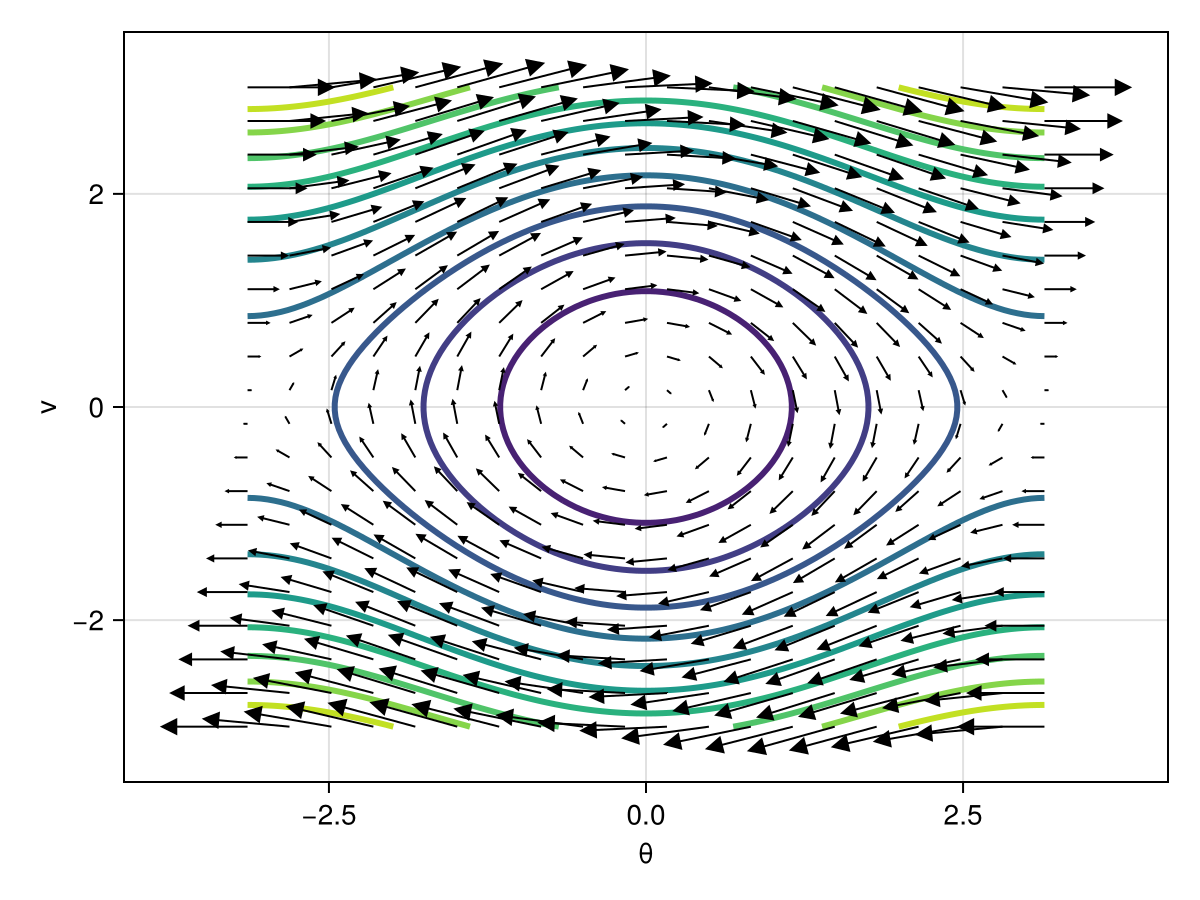

CairoMakie.Screen{IMAGE}


In [6]:
f=Figure()
ax=Axis(f[1,1])
scene = Makie.contour!(θ_finelist,v_finelist,E_finegrid, levels = 10, linewidth = 3)
Makie.arrows!(θ_list,v_list,0.2 .*dθdt_grid,0.2 .*dvdt_grid,arrowsize=vec(norms))
ax.xlabel="θ"
ax.ylabel="v"
display(f)

That looks quite a bit better.

## Stepping

To calculate the dynamics we will introduce the idea of a *stepping rule*.  The simplest stepping rule takes $(\theta,v)$ at time $t$, and gives us $(\theta,v)$ at time $t+\delta t$.  There are, however, higher order stepping rules that take a sequence of earlier values.

Thus we define $(\theta_i,v_i)=(\theta(t_i),v(t_i))$, where $t_i=t_0+i\times \delta t$.

The simplest way to derive a stepping rule is to make a finite difference approximation in our equations of motion:
\begin{align}
\frac{d \theta}{dt}&= v \\
\frac{d v}{dt}&=- \sin(\theta)
\end{align}
We write
$$
\left(\frac{d\theta}{dt}\right)(t_i)\approx \frac{\theta_{i+1}-\theta_i}{\delta t}
$$
This then gives the *Forward Euler* approximation
\begin{align}
 \theta_{i+1}&= \theta_i + v_i \delta t \\
v_{i+1}&=v_i - \sin(\theta_i) \delta t
\end{align}

This is easy to code.  We will combine the phase space variables into a vector $x=[\theta,v]$.

In [7]:
function eulerstep(x,dxdt,t,deltat)
    return x+deltat*dxdt(x,t)
end

eulerstep(;x,dxdt,t,deltat)=eulerstep(x,dxdt,t,deltat)

function pendulum_dxdt(x,t)
    (theta,v)=x
    return [v,-sin(theta)]
end

pendulum_dxdt (generic function with 1 method)

We can then make some control structure to evolve the pendulum

In [8]:
function evolve(x0,dxdt,timerange,stepper=eulerstep)
    ti,tf,dt=timerange
    numsteps=floor(Int,(tf-ti)/dt)
    x=collect(x0) #converts to a vector
                  #works fine without "collect" if you restrict input to vectors
    result=Array{typeof(x)}(undef,numsteps+1)
    result[1]=x
    t=ti
    for j in 1:numsteps
        x=stepper(x=x,dxdt=dxdt,t=t,deltat=dt)
        result[j+1]=x
        t+=dt
    end
    return result
end

evolve(;x0,dxdt,timerange,stepper=eulerstep)=evolve(x0,dxdt,timerange,stepper)

evolve (generic function with 3 methods)

If we evolve the trajectory, it seems to work OK

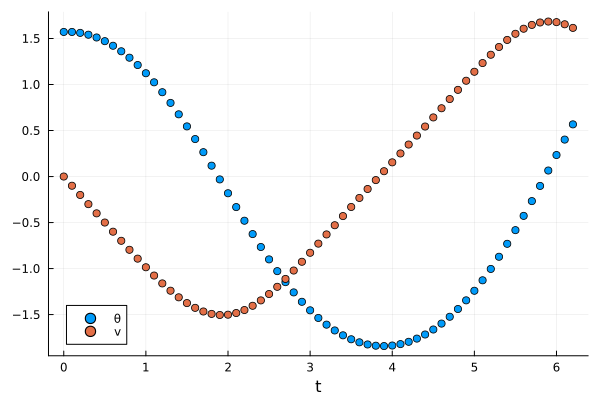

In [9]:
ev1=evolve([pi/2,0.],pendulum_dxdt,(0,2*pi,0.1))
times=0:0.1:2*pi
Plots.scatter(times,first.(ev1),label="θ",xlabel="t")
Plots.scatter!(times,last.(ev1),label="v",xlabel="t")

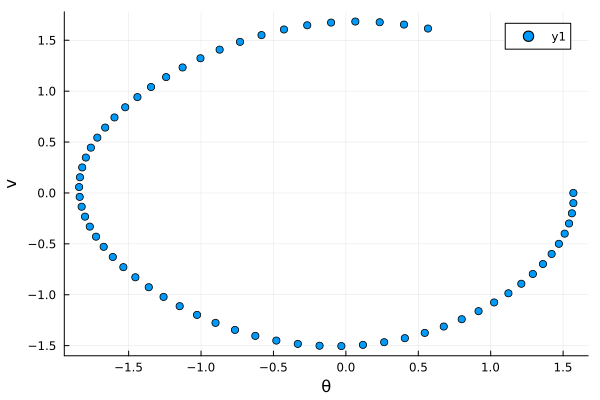

In [10]:
Plots.scatter(first.(ev1),last.(ev1),xlabel="θ",ylabel="v")

If we run for longer we see some trouble though

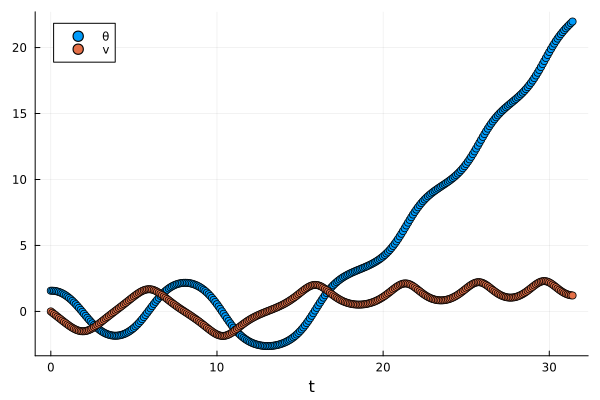

In [11]:
ev2=evolve((pi/2,0.),pendulum_dxdt,(0,10*pi,0.1))
times2=0:0.1:10*pi
Plots.scatter(times2,first.(ev2),label="θ",xlabel="t")
Plots.scatter!(times2,last.(ev2),label="v",xlabel="t")

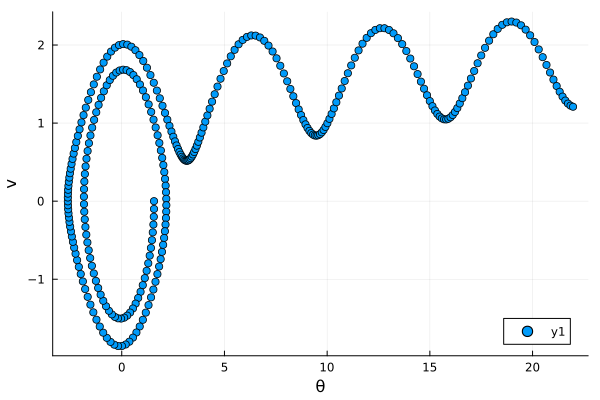

In [12]:
Plots.scatter(first.(ev2),last.(ev2),xlabel="θ",ylabel="v")

Here is an approach to making an animation of the result.  This uses a rather generic strategy, where we simply create a sequence of frames, and assemble them into a movie file:  In this case an animated gif.  The Jupyter notebook then displays this animated gif using standard html.

The down-side of this approach is that it is not "live".  We are using canned data to produce the frames.  As implemented here, it is also slow.  It takes longer to generate the frames than it did to produce the data.

The up-side is that it is completely generic.  You can make arbitrary images for each frame.  It also produces a file that you can show to someone else, outside of a notebook.

In [13]:
# Since it takes some time to generate the frames we want to show
#  a progress bar.  This is good practice for any slow code.
using ProgressMeter

"""
    animatependulum(trajectory,times;traillength=10)

Generates an animation of a pendulum.

`trajectory` should be a list of (theta,v) values
`times` is a list of times

If you leave off `times` it takes them to be integers.
"""
function animatependulum(trajectory,times;traillength=10)
    
    # first we extract the x and y coordinates
    xvals=[sin(theta) for (theta,v) in trajectory]
    yvals=[-cos(theta) for (theta,v) in trajectory]

    # print out a message to let the user know things are starting
    @info "Animating Pendulum"
    # Make a progress bar
    progress_meter=Progress(length(xvals),desc="Generating frames: ")

    # Loop to generate the frames
    # the `@animate` is a macro defined by Plots.jl
    # which takes the plot generated in each loop
    # and wraps i t
    anim =  @animate for i in eachindex(xvals)
        update!(progress_meter,i)
        # Generate path
        x_path = xvals[1:i]
        y_path = yvals[1:i]
    
        plt=Plots.plot(x_path, y_path, linecolor = :orange,xlabel="x",ylabel="y")
        Plots.plot!(xlims = (-1.1, 1.1), xticks = -1:0.5:1)
        Plots.plot!(ylims = (-1.1, 1.1), yticks = -1:0.5:1)
        Plots.scatter!(
            x_path,
            y_path,
            color = :orange,
            markersize = 2,
            markerstrokewidth = 0,
            markerstrokecolor = :orange,
        )


        if(i>1)
            # Generate chem-trails
            x_trail=reverse(xvals[max(1,i-traillength):i])
            y_trail=reverse(yvals[max(1,i-traillength):i])
            n=length(x_trail)
            widths =range(10, 1, length = n)
            alpha = range(1, 0, length = n)

            Plots.plot!(x_trail,y_trail,linewidth =widths,seriesalpha =alpha,label=false)
        end
    
        # plot pendulum
    
        x_pendulum = [0, xvals[i]]
        y_pendulum = [0, yvals[i]]

        Plots.plot!(x_pendulum,y_pendulum, legend = false,aspect_ratio = :equal, linewidth=5)
        Plots.plot!(xlims = (-1.1, 1.1), xticks = -1:0.5:1)
        Plots.plot!(ylims = (-1.1, 1.1), yticks = -1:0.5:1)
        Plots.scatter!(x_pendulum,y_pendulum)
    
        Plots.annotate!(0, 0.5, "time="*string(round(times[i];digits=2)))
    end
    Plots.gif(anim, fps = 10)
end 

animatependulum(trajectory;traillength=10)=
    animatependulum(trajectory,1:length(trajectory);traillength)
    

animatependulum (generic function with 2 methods)

[ Info: Animating Pendulum


Generating frames:   1%|▎                               |  ETA: 0:00:42

Generating frames:   4%|█▎                              |  ETA: 0:00:19

Generating frames:   7%|██▏                             |  ETA: 0:00:12

Generating frames:   9%|███                             |  ETA: 0:00:10

Generating frames:  12%|███▊                            |  ETA: 0:00:08

Generating frames:  14%|████▋                           |  ETA: 0:00:07

Generating frames:  17%|█████▎                          |  ETA: 0:00:07

Generating frames:  19%|██████▏                         |  ETA: 0:00:06

Generating frames:  22%|██████▉                         |  ETA: 0:00:06

Generating frames:  24%|███████▋                        |  ETA: 0:00:05

Generating frames:  26%|████████▍                       |  ETA: 0:00:05

Generating frames:  29%|█████████▎                      |  ETA: 0:00:05

Generating frames:  31%|██████████                      |  ETA: 0:00:04

Generating frames:  34%|██████████▊                     |  ETA: 0:00:04

Generating frames:  36%|███████████▌                    |  ETA: 0:00:04

Generating frames:  38%|████████████▎                   |  ETA: 0:00:04

Generating frames:  40%|████████████▉                   |  ETA: 0:00:04

Generating frames:  43%|█████████████▋                  |  ETA: 0:00:03

Generating frames:  45%|██████████████▍                 |  ETA: 0:00:03

Generating frames:  47%|███████████████                 |  ETA: 0:00:03

Generating frames:  49%|███████████████▊                |  ETA: 0:00:03

Generating frames:  51%|████████████████▍               |  ETA: 0:00:03

Generating frames:  53%|█████████████████▏              |  ETA: 0:00:03

Generating frames:  56%|█████████████████▊              |  ETA: 0:00:03

Generating frames:  58%|██████████████████▌             |  ETA: 0:00:02

Generating frames:  60%|███████████████████▎            |  ETA: 0:00:02

Generating frames:  62%|███████████████████▉            |  ETA: 0:00:02

Generating frames:  64%|████████████████████▋           |  ETA: 0:00:02

Generating frames:  66%|█████████████████████▎          |  ETA: 0:00:02

Generating frames:  68%|█████████████████████▉          |  ETA: 0:00:02

Generating frames:  70%|██████████████████████▌         |  ETA: 0:00:02

Generating frames:  73%|███████████████████████▎        |  ETA: 0:00:02

Generating frames:  75%|███████████████████████▉        |  ETA: 0:00:01

Generating frames:  77%|████████████████████████▌       |  ETA: 0:00:01

Generating frames:  78%|█████████████████████████▏      |  ETA: 0:00:01

Generating frames:  80%|█████████████████████████▊      |  ETA: 0:00:01

Generating frames:  82%|██████████████████████████▎     |  ETA: 0:00:01

Generating frames:  84%|██████████████████████████▉     |  ETA: 0:00:01

Generating frames:  86%|███████████████████████████▌    |  ETA: 0:00:01

Generating frames:  88%|████████████████████████████▏   |  ETA: 0:00:01

Generating frames:  90%|████████████████████████████▊   |  ETA: 0:00:01

Generating frames:  92%|█████████████████████████████▍  |  ETA: 0:00:00

Generating frames:  94%|██████████████████████████████  |  ETA: 0:00:00

Generating frames:  96%|██████████████████████████████▋ |  ETA: 0:00:00

Generating frames:  97%|███████████████████████████████▏|  ETA: 0:00:00

Generating frames:  99%|███████████████████████████████▊|  ETA: 0:00:00

Generating frames: 100%|████████████████████████████████| Time: 0:00:05


[ Info: Saved animation to /Users/emueller/Documents/Work Laptop 2011-2012/PHYS 4480-7680 Computational Physics/book/tmp.gif


Plots.AnimatedGif("/Users/emueller/Documents/Work Laptop 2011-2012/PHYS 4480-7680 Computational Physics/book/tmp.gif")
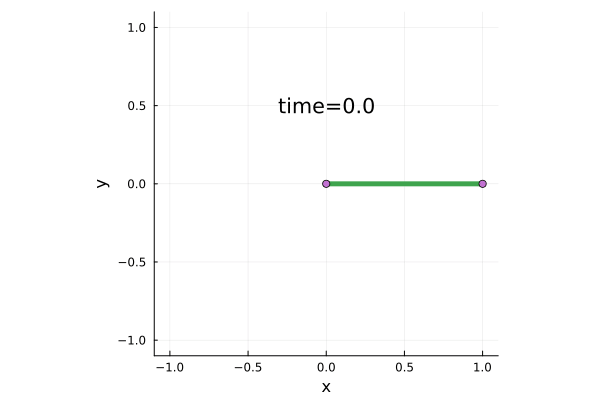

In [14]:
animatependulum(ev2,times2)

The problem that happens is that the Euler stepper is always taking a step which is tangent to the iso-energy contour.  For an infinitesmal step this will leave the energy unchanged -- but for a finite step size the energy increases.

If we make the stepsize even larger, then the problem is clear

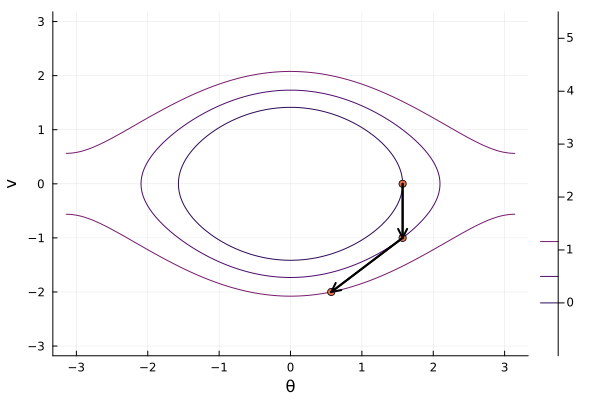

In [15]:
x0=[pi/2,0.]
energy0=E_function(x0...)
x1=eulerstep(x=x0,dxdt=pendulum_dxdt,t=0.,deltat=1)
energy1=E_function(x1...)
x2=eulerstep(x=x1,dxdt=pendulum_dxdt,t=0.,deltat=1)
energy2=E_function(x2...)
Plots.contour(θ_finelist,v_finelist,E_finegrid',levels=[energy0,energy1,energy2])
Plots.scatter!(Tuple.([x0,x1,x2]),label=false,xlabel="θ",ylabel="v")
Plots.plot!(Tuple.([x0,x1]),arrow=true,color=:black,linewidth=2,label="")
Plots.plot!(Tuple.([x1,x2]),arrow=true,color=:black,linewidth=2,label="")

The problem gets better if we take a smaller step size -- but it doesn't go away

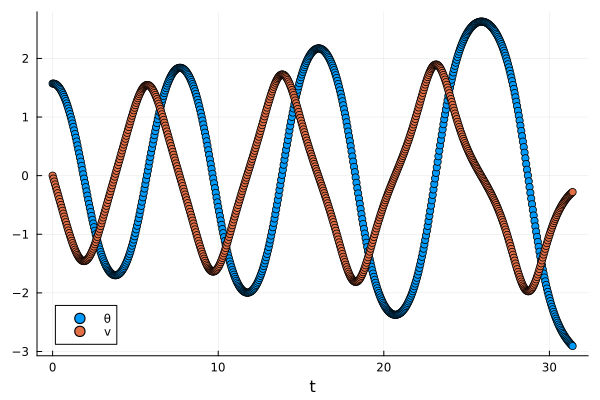

In [16]:
ev3=evolve((pi/2,0.),pendulum_dxdt,(0,10*pi,0.05))
times3=0:0.05:10*pi
Plots.scatter(times3,first.(ev3),label="θ",xlabel="t")
Plots.scatter!(times3,last.(ev3),label="v",xlabel="t")

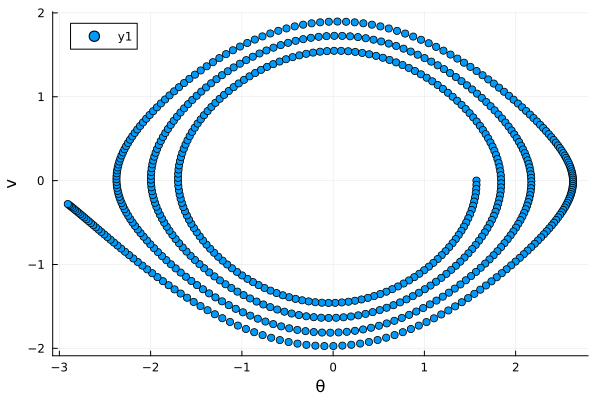

In [17]:
Plots.scatter(first.(ev3),last.(ev3),xlabel="θ",ylabel="v")

There are two generic approaches to fixing the problem:  Higher order methods, or Symplectic methods

## Higher order methods

There are a number of different strategies for deriving more sophisticated stepping rules.  The most common are the Runge-Kutta algorithms.  This family of algorithms is best illustrated by the Second-order Runge Kutta, or *midpoint* method.

To simplify notation, we abstract our differential equation to
$$
\frac{dx}{dt}=f(x,t)
$$
where $x$ is understood to be a vector.

Starting from point $x_j$, at time $t_j$.  One first takes half an Euler step to produce
$$
\bar x_{j+1/2}=x_j+f(x_j,t_j) \delta t/2.
$$
Then you calculate the slope at that new point
$$
k_2=f(\bar x_{j+1/2},t_{j+1/2})
$$
where $t_{j+1/2}=t_j+\delta t/2$.
This slope is then used to evolve from the original point:
$$
x_{j+1}=x_j+k_2 \delta t .
$$

This is referred to as a second order method, as the error in one step scales as $\delta t^3$.  For comparison, the Euler approach is first order, with an error scaling as $\delta t^2$.

The most common way to describe the Second order Runge-Kutta is
\begin{align}
k_1&= f(x_j,t_j)\\
k_2&= f(x_j+k_1 \delta t/2,t_j+\delta t/2)\\
x_{j+1}&= x_j+k_2 \delta t
\end{align}
This is easy to implement

In [18]:
function rk2step(x,dxdt,t,deltat)
    k1=dxdt(x,t)
    k2=dxdt(x+k1*(deltat/2),t+deltat/2)
    return x+k2*deltat
end

rk2step(;x,dxdt,t,deltat)=rk2step(x,dxdt,t,deltat)

rk2step (generic function with 2 methods)

In [19]:
eulerstep(x0,pendulum_dxdt,5.,0.1)

2-element Vector{Float64}:
  1.5707963267948966
 -0.1

In [20]:
rk2step(x0,pendulum_dxdt,5.,0.1)

2-element Vector{Float64}:
  1.5657963267948967
 -0.1

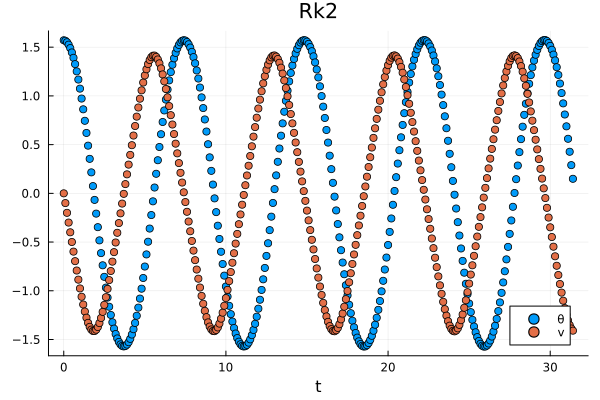

In [21]:
rk2ev2=evolve((pi/2,0.),pendulum_dxdt,(0,10*pi,0.1),rk2step)
times2=0:0.1:10*pi
Plots.scatter(times2,first.(rk2ev2),label="θ",xlabel="t",title="Rk2")
Plots.scatter!(times2,last.(rk2ev2),label="v",xlabel="t")

The structure of a generic *explicit* Runge-Kutta algorithm is:
\begin{align}
k_1&=f(x_j,t_j)\\
k_2&=f(x_j+a_{21} k_1 \delta t,t+c_2 \delta t)\\
k_3&=f(x_j+a_{31} k_1 \delta t+a_{32} k_2 \delta t,t+c_3 \delta t)\\
\vdots\\
k_s&=f(x_j + \sum_i a_{si} k_i \delta t,t+c_s \delta t)
\end{align}
and then
$$
x_{j+1}=x_j +\sum_i b_i k_i.
$$
One refers to this as a $s$-stage method.  One adjusts the $a$'s, $b$'s, and $c$'s to minimize the error.  This error in one step scales as $\delta t^{p+1}$, defining the order, $p$.

One can explicitly do this minimization, but it is not particularly revealing.  The most popular Runge-Kutta algrithm is a four stage method, RK4, which you can look up on Wikipedia:
\begin{align}
k_1 &= f(x_j,t_j)\\
k_2 &= f(x_j+ k_1 \delta t/2,t_j+\delta t/2)\\
k_3 &= f(x_j+ k_2 \delta t/2,t_j+\delta t/2)\\
k_4 &= f(x_j+ k_3 \delta t,t_j+\delta t)\\
x_{j+1} &= x_j + (k_1+2 k_2 +2 k_3+k_4) \delta t/6.
\end{align}
Even though the derivation is not transparent, it is trivial to implement.

In [22]:
function rk4step(x,dxdt,t,deltat)
    k1=dxdt(x,t)
    k2=dxdt(x+k1*(deltat/2),t+deltat/2)
    k3=dxdt(x+k2*(deltat/2),t+deltat/2)
    k4=dxdt(x+k3*deltat,t+deltat)
    return x+(k1+2*k2+2*k3+k4)*(deltat/6)
end

rk4step(;x,dxdt,t,deltat)=rk4step(x,dxdt,t,deltat)

rk4step (generic function with 2 methods)

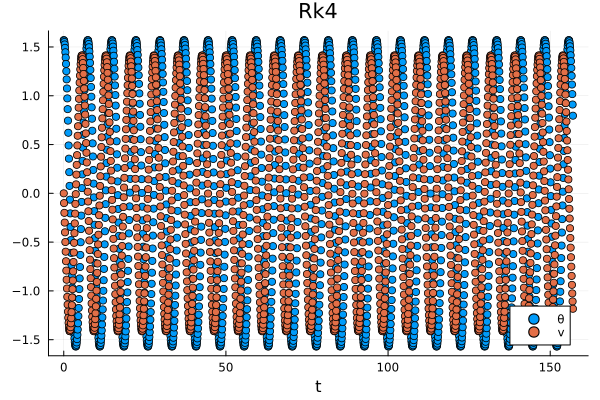

In [23]:
rk4ev=evolve([pi/2,0.],pendulum_dxdt,(0,50*pi,0.1),rk4step)
rk4times=0:0.1:50*pi
Plots.scatter(rk4times,first.(rk4ev),label="θ",xlabel="t",title="Rk4")
Plots.scatter!(rk4times,last.(rk4ev),label="v",xlabel="t")

As with the Euler method, RK4 does not explicitly conserve energy -- though it gets better if you take the timesteps to be smaller.  It is pretty good if you keep your timesteps small.

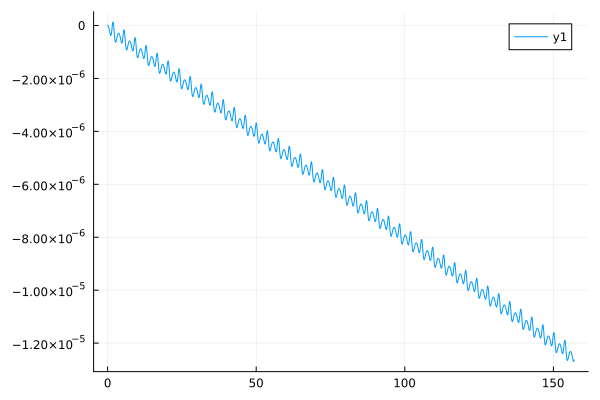

In [24]:
energies=[E_function(x...) for x in rk4ev]
Plots.plot(rk4times,energies)

Our integrator can be further improved if we take a dynamical timestep. [See chapter 17.2 of Numerical Recipies](http://numerical.recipes/book.html).

## Container objects

It is probably now time to make a detour into describing some of Julia's container objects

In [25]:
@show at=(1.,2.) #tuple
@show ac=[1.,2.] #column vector
@show ac2=[1.;2.] #column vector
@show ar=[1. 2.]; #row vector

at = (1.0, 2.0) = (1.0, 2.0)
ac = [1.0, 2.0] = [1.0, 2.0]
ac2 = [1.0; 2.0] = [1.0, 2.0]
ar = [1.0 2.0] = 

[1.0 2.0]


Tuples do not know how to do algebra

In [26]:
2*at

LoadError: MethodError: no method matching *(::Int64, ::Tuple{Float64, Float64})

[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:578[24m[39m
[0m  *(::T, [91m::T[39m) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}
[0m[90m   @[39m [90mBase[39m [90m[4mint.jl:88[24m[39m
[0m  *(::Union{Int16, Int32, Int64, Int8}, [91m::BigInt[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mgmp.jl:552[24m[39m
[0m  ...


Instead to work with `tuples` you need to do element-wise operations

In [235]:
2 .*at

(2.0, 4.0)

vectors do know how to do algebra

In [231]:
2*ac

2-element Vector{Float64}:
 2.0
 4.0

In [232]:
2*ar

1×2 Matrix{Float64}:
 2.0  4.0

In [234]:
ac+ac2

2-element Vector{Float64}:
 2.0
 4.0

You can also do inner and outer products

In [239]:
ar*ac # a row vector times a column vector is a number (stored as a 1x1 matrix)

1-element Vector{Float64}:
 5.0

In [242]:
only(ar*ac) # strips out the number from the 1x1 matrix

5.0

In [243]:
ac*ar # a column vector times a row vector is a 2x2 matrix

2×2 Matrix{Float64}:
 1.0  2.0
 2.0  4.0

To convert a tuple to a vector

In [397]:
collect(at)

2-element Vector{Float64}:
 1.0
 2.0

To convert a vector to a tuple

In [402]:
Tuple(ac)

(1.0, 2.0)

In [405]:
Tuple.([ac,ac])

2-element Vector{Tuple{Float64, Float64}}:
 (1.0, 2.0)
 (1.0, 2.0)

### Beyond Runge-Kutta

While Runge-Kutta algorithms are the most common time-steppers, they are hardly the only ones (or the best ones).  Numerical Recipies is fond of the Bulirsch-Stoer Method.  If you need to write your own differential equation solver, have a look at chapter 17.3.

In practice, one typically turns to packages.

The most popular package for differential equation solving in Julia is `DifferentialEquations.jl`.   There is also `DynamicalSystems.jl` and `OrdinaryDiffEq.jl`

This is much less fun than writing our own integrator, but most of the time it is better to use one of these packages

In [210]:
using DifferentialEquations

In our time evolving function, we passed the following information:

- `x0` -- the initial conditions
- `dxdt(x,t)` -- a function of `(x,t)` which gives the derivatives
-  `timerange=(ti,tf,dt)`
-  `stepper` -- the algorithm for time-stepping

In `DifferentialEquations.jl` they create an object which stores most of that information 
- `x0` -- the initial conditions
- `dxdt(x,p,t)` -- a function of `(x,p,t)` which gives the derivatives
-  `tspan=(ti,tf)`

The function `dxdt` has an extra argument `p` -- which is used for passing parameter values to it.  The function must take that argument, but it can ignore it.  It should return a vector or a matrix, so that one can do algebra with it.

In [410]:
function pendulum_dxdt(x,p,t)
    (theta,v)=x
    return [v, -sin(theta)]
end
x0=[pi/2, 0.]
tspan=[0., pi*10]
args1=ODEProblem(pendulum_dxdt,x0,tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 31.41592653589793)
u0: 2-element Vector{Float64}:
 1.5707963267948966
 0.0

In [411]:
sol=solve(args1);

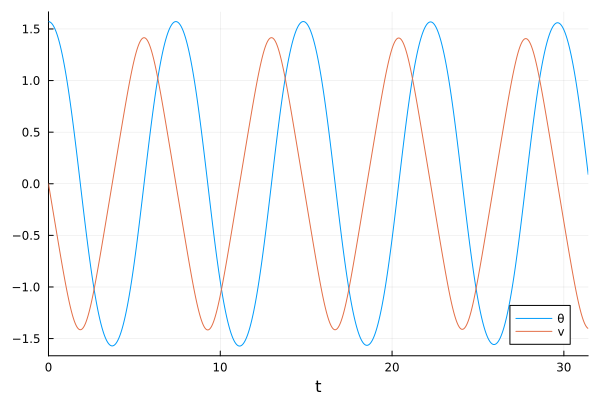

In [412]:
Plots.plot(sol,xlabel="t",label=["θ" "v"])

The solution acts like a function, which we can just evaluate at any arbitrary time

In [415]:
sol(10)

2-element Vector{Float64}:
 -0.9483713986952461
 -1.0808416834229255

The underlying data can be extracted 

In [416]:
data=sol.u
times=sol.t
thetas=first.(data)

40-element Vector{Float64}:
  1.5707963267948966
  1.5707958274309088
  1.5707359037523996
  1.5657685871275049
  1.5155423845226306
  1.3282643422945346
  0.9224657895776813
  0.18783083908755083
 -0.5574551139986381
 -1.1614592767933678
 -1.5441352805853268
 -1.377839476819898
 -0.5504662804129894
  ⋮
  0.578594530645159
  1.404389789156501
  1.1814031604413406
  0.20532186934988528
 -1.2281144936436867
 -1.556001142242423
 -0.8961882130306751
  0.5485444587794603
  1.3906451010915006
  1.211002665605734
  0.2772831811363994
  0.09066683299268166

Note the stored times are not equally spaced

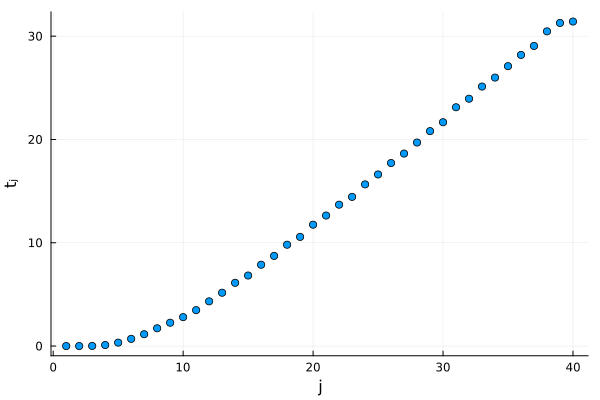

In [417]:
Plots.scatter(times,xlabel="j",ylabel="tⱼ",label="")

Apparently the first few times were close together as it tried to adaptively find the best timestep.

We can ask the solver to use a [particular algorithm](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) -- for example RK4

In [425]:
RKsol=solve(args1,RK4());

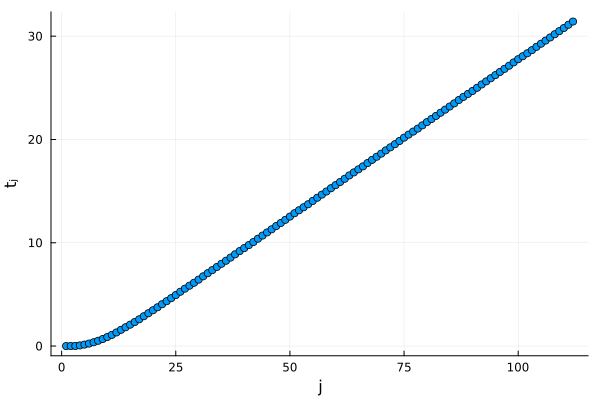

In [426]:
Plots.scatter(RKsol.t,xlabel="j",ylabel="tⱼ",label="")

Note:  Energy conservation is not perfect.  One can do better however if one asks the solver for higher precision.

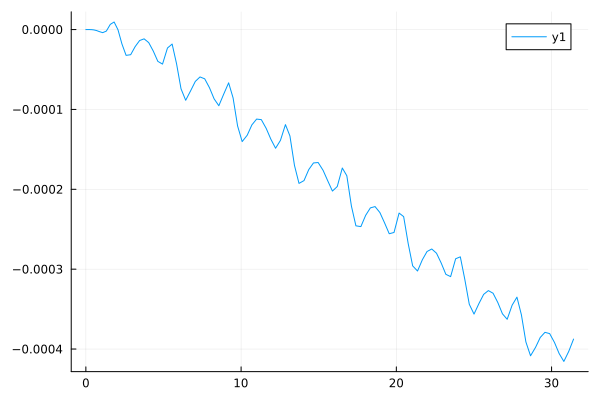

In [428]:
elist=[E_function(x...) for x in RKsol.u]
Plots.plot(RKsol.t,elist)